In [2]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#correct the modern Julian dates and exposure times for the Earth's motion around the Sun
#convert wavelength axis to velocity axis in km/s
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SpectralCoord
barycorrlist=[]
sc_nm_list = []
sc_kms_list = []
mjd=[]
ltt_barylist=[]
bjdlist = []
for i in range(1, 22):
    hdul=fits.open(f'VIS_{i:02}.fits')
    mjd.append(hdul[0].header['MJD-OBS'])
    
for i in range(1, 22):
    file = f'VIS_{i:02}.fits'
    hdul = fits.open(file)
    flux_data = hdul[0].data
    header = hdul[0].header
    exposuretime = header['EXPTIME']
    start_wavelength_nm = header['CRVAL1']
    wavelength_step_nm = header['CDELT1']
    pixel_num = np.arange(len(flux_data))
    wavelength_nm = start_wavelength_nm + (pixel_num * wavelength_step_nm)
    sc = SpectralCoord(wavelength_nm, unit='nm')
    sc_kms = sc.to(u.km / u.s, doppler_convention='optical', doppler_rest=656.276 * u.nm)
    sc_nm_list.append(sc)
    sc_kms_list.append(sc_kms)
    
    from astropy import time, coordinates as coord, units as u
    VIS = coord.SkyCoord("21:21:18.6", "-09:43:29.0", unit=(u.hourangle, u.deg), frame='icrs')
    paranal = coord.EarthLocation.of_site('paranal')
    times = time.Time([mjd[i-1]+((exposuretime/2) / 86400.0)], format='mjd', scale='utc', location=paranal)
    barycorr = VIS.radial_velocity_correction(obstime=times)
    barycorrlist.append(barycorr)
    ltt_bary = times.light_travel_time(VIS)
    ltt_barylist.append(ltt_bary)
    time_barycentre = times.tdb + ltt_bary.value.item()
    bjdlist.append(time_barycentre)

    
bary_kmslist = []
for i in range (1,22):
    bary_nm = sc_nm_list[i-1].with_radial_velocity_shift(barycorrlist[i-1])
    bary_kms = bary_nm.to(u.km / u.s, doppler_convention='optical', doppler_rest=656.276 * u.nm)
    bary_kmslist.append(bary_kms)

In [4]:
output_filename = 'trailing_data_with_errors.npz'
data = np.load(output_filename)
trailing_data = data['mean_flux']
trailing_data_error = data['error_flux']
common_velocity_axis = data['velocity_axis']
fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
min_v, max_v, binsize = -750, 750, 10
velocity_mask = (common_velocity_axis >= min_v) & (common_velocity_axis <= max_v)

/tmp/ipykernel_350319/4006196915.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


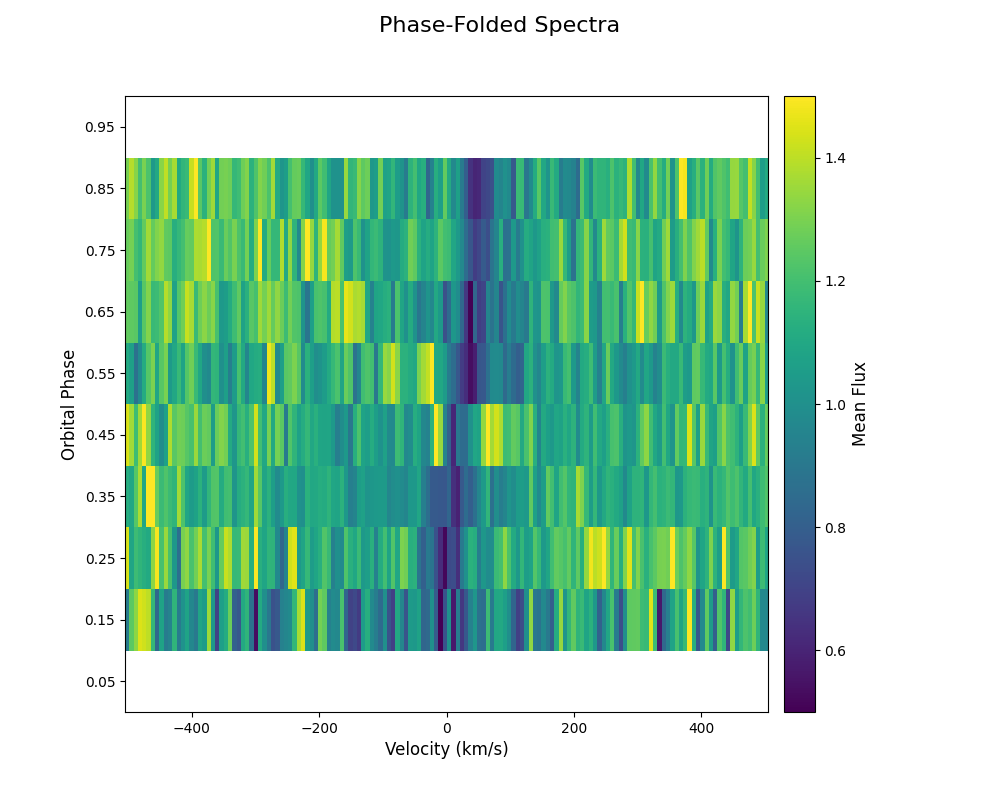

In [5]:
#produce orbital phase from the bjdlist which contains the MBJD Modern Barycentre Julian Dates
def orbitalphasefunc():
    T0_val = 59385.541376
    P = 0.0953979016
    T0 = time.Time(T0_val, format='mjd', scale='tdb')
    orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]
    return orbitalphase
    
#plot the spectra by binning the orbital phases
def plot_orbitalphase_spectra(file_list, bary_kmslist, min_v, max_v, binsize, phase_bin_size):
    %matplotlib widget
    n_files = len(trailing_data)

    median_flux = np.median(trailing_data)
    
    normalised_trailing_data = trailing_data/median_flux
    normalised_error = trailing_data_error/median_flux
    vmin = 0.5 * np.median(normalised_trailing_data)
    vmax = 1.5 * np.median(normalised_trailing_data)
    normalised_trailing_data_masked = normalised_trailing_data[:,velocity_mask]
    
    phase_bins = np.arange(0.0, 1.0, phase_bin_size)
    binned_spectra_list = []
    orbitalphase = orbitalphasefunc()

    for start_phase in phase_bins:
        end_phase = start_phase + phase_bin_size
        phase_mask = (np.array(orbitalphase) >= start_phase) & (np.array(orbitalphase) < end_phase)
        fluxes_in_bin = normalised_trailing_data_masked[phase_mask]

        if fluxes_in_bin.shape[0] > 0:
            mean_flux_for_bin = np.nanmean(fluxes_in_bin, axis=0)
        else:
            mean_flux_for_bin = np.full(len(common_velocity_axis[velocity_mask]), np.nan)

        binned_spectra_list.append(mean_flux_for_bin)

    phase_data = np.ma.masked_invalid(np.array(binned_spectra_list))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(phase_data, extent=[min_v - binsize / 2, max_v + binsize / 2, 0, 1],
                   origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Mean Flux', fontsize=12)

    ax.set_xlabel('Velocity (km/s)', fontsize=12)
    ax.set_ylabel('Orbital Phase', fontsize=12)
    plt.suptitle('Phase-Folded Spectra', fontsize=16)

    ax.set_yticks(phase_bins + phase_bin_size / 2)
    ax.set_yticklabels([f'{p:.2f}' for p in phase_bins + phase_bin_size / 2])
    plt.show()

fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
plot_orbitalphase_spectra(fits_files, bary_kmslist, -500, 500, 10, 0.1)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.modeling import models
from scipy.optimize import minimize

P = 0.0953979016
orbitalphase = orbitalphasefunc()
#modified function to return flux arrays instead of plotting
def plot_trailing_spectra_modified(file_list, bary_kmslist, min_v, max_v, binsize=10):
    n_files = len(trailing_data) #this is to calculate the number of spectra, not fluxes
    median_flux = np.median(trailing_data) #this is to take the median of all the fluxes across all spectra
    normalised_trailing_data = trailing_data/median_flux
    normalised_error = trailing_data_error/median_flux
    normalised_trailing_data_masked = normalised_trailing_data[:,velocity_mask]
    normalised_error_masked = normalised_error[:,velocity_mask]
    
    vmin = 0.5 * np.median(normalised_trailing_data_masked)
    vmax = 1.5 * np.median(normalised_trailing_data_masked)
#vmin, vmax are flux values.
    return normalised_trailing_data_masked, normalised_error_masked, vmin, vmax, n_files


/tmp/ipykernel_350319/4006196915.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


In [7]:
#function of the model with smearing effects   
def generate_model_data(params):
    """
    Generates the model and bins it down to match your data.
    """
    (gamma_wd, k_wd, wd_amp, wd_std,
     gamma_bd, k_emis, bd_amp, bd_std,
     slope, intercept) = params
    
    model_spectra_list = []

    exposure_time_s = 600.0
    n_phase_bins = 18
    time_offsets = np.linspace(-exposure_time_s / 2.0, exposure_time_s / 2.0, n_phase_bins)
    phase_offsets = time_offsets / (P * 86400.0)
    
    for mid_phase in orbitalphase:
        sub_spectra = []
        for offset in phase_offsets:
            current_phase = mid_phase + offset
            linear_background = models.Linear1D(slope=slope, intercept=intercept)
            mean_wd = gamma_wd - k_wd * np.sin(2 * np.pi * current_phase)
            gauss_wd = models.Gaussian1D(amplitude=wd_amp, mean=mean_wd, stddev=wd_std)
            mean_bd = gamma_bd + k_emis * np.sin(2 * np.pi * current_phase)
            amplitude_bd = bd_amp * (1 - np.cos(2 * np.pi * current_phase)) / 2.0
            gauss_bd = models.Gaussian1D(amplitude=amplitude_bd, mean=mean_bd, stddev=bd_std)
            composite_model = linear_background + gauss_wd + gauss_bd
            model_flux_for_bin = composite_model(common_velocity_axis[velocity_mask])
            sub_spectra.append(model_flux_for_bin)

        smeared_spectrum = np.mean(sub_spectra, axis=0) 
        model_spectra_list.append(smeared_spectrum)  

    return np.array(model_spectra_list)

In [8]:
normalised_trailing_data_masked, normalised_error_masked, _, _, _= plot_trailing_spectra_modified(fits_files, bary_kmslist, min_v, max_v, binsize)

def chisqNM(params, normalised_trailing_data_masked, common_velocity_axis, normalised_error_masked):
    """
    Objective function for scipy.optimize.minimize. (Nelder Mead)

    It takes the parameters to be optimized as the first argument.
    """
    model_array = generate_model_data(params)
    chi2 = np.sum(((normalised_trailing_data_masked - model_array) / normalised_error_masked)**2)
    
    return chi2

In [11]:
initialparams = [
        30.0,    # gamma_wd
        35.0,   # k_wd
        -0.45,     # wd_amp
        20.0,    # wd_std
        10.0,    # gamma_bd
        325.0,   # k_emis
        0.60,     # bd_amp
        20.0,    # bd_std
        -0.00005,   # slope
        1.0  ]    # intercept

args = (normalised_trailing_data_masked, common_velocity_axis[velocity_mask], normalised_error_masked)

In [12]:
chi2initial = chisqNM(initialparams, normalised_trailing_data_masked, common_velocity_axis[velocity_mask], normalised_error_masked)
print(chi2initial)

6881.903894036043


In [10]:
results = minimize(
    chisqNM,          # The function to minimize
    x0=initialparams,           # The initial guess for the parameters
    args=args,     # Tuple of additional, fixed arguments
    method='Nelder-Mead'      )

# The best-fit parameters 
best_fit_params = results.x
print("Best-fit parameters:", best_fit_params)

# The minimum chi-squared value 
min_chi2 = results.fun
print("Minimum chi-squared:", min_chi2)

KeyboardInterrupt: 

In [11]:
#using leastsq method instead of L-BFGS-B
from scipy.optimize import leastsq

def chisqleastsq(params, normalised_trailing_data_masked, common_velocity_axis, error_array):
    """
    Objective function for scipy.optimize.leastsq.
    It should return a 1-D array of residuals.
    """
    model_array = generate_model_data(params)

    # Calculate the normalized residuals (NOT SQUARED, because leastsq will square and sum it)
    residuals = (normalised_trailing_data_masked - model_array) / error_array
 
    return residuals.flatten() #need to ensure its 1D array (input data are 2D)
    
best_fit_parameters= [3.61632761e+01,  4.34797812e+01, -4.36608846e-01 , 4.46507515e+01,
  3.93501527e+00 , 3.40218807e+02  ,4.27364216e-01 , 2.22811895e+01,
 -9.93491440e-06 , 1.13485997e+00]
resultsleastsq = leastsq(chisqleastsq, x0=best_fit_parameters, args=args, Dfun=None, full_output=True, 
        col_deriv=True, ftol=1.49012e-08, xtol=1.49012e-08, gtol=0.0, maxfev=0, epsfcn=None, factor=100, diag=None)

leastsqparams = resultsleastsq[0]
cov_x = resultsleastsq[1]
infodict = resultsleastsq[2]
residuals_at_minimum = infodict['fvec'] #fvec is the function evaluated at the output, which is the residuals
min_chi2 = np.sum(residuals_at_minimum**2)

num_data_points = len(infodict['fvec'])
num_params = len(leastsqparams)
dof = num_data_points - num_params
reduced_chi2 = min_chi2 / dof
scaled_cov_x = cov_x * reduced_chi2
leastsqerrors = np.sqrt(np.diag(scaled_cov_x))

print(leastsqparams, leastsqerrors, min_chi2)

[ 3.76788011e+01  4.53658700e+01 -4.17207264e-01  5.02974774e+01
  1.98337287e+01  3.33838906e+02  4.37246818e-01  2.38910124e+01
 -1.79325494e-05  1.13647558e+00] [2.50078964e+00 3.38327810e+00 1.84795069e-02 2.63244236e+00
 4.60452225e+00 5.61712907e+00 8.69273442e-02 5.50379560e+00
 8.56469034e-06 4.19334607e-03] 5002.417345919974


In [15]:
print(normalised_trailing_data_masked.shape)

(21, 150)


In [12]:

var_names = ["gamma_wd", "k_wd", "wd_amp", "wd_std", "gamma_bd", 
             "k_emis", "bd_amp", "bd_std", "slope", "intercept"]

# Print upper triangle of cov_x (excluding diagonal)
print("Upper triangle covariances:\n")
for i in range(10):
    for j in range(i + 1, 10):
        print(f"Cov({var_names[i]}, {var_names[j]}) = {cov_x[i, j]:.4f}")


Upper triangle covariances:

Cov(gamma_wd, k_wd) = 0.5515
Cov(gamma_wd, wd_amp) = 0.0004
Cov(gamma_wd, wd_std) = -0.1456
Cov(gamma_wd, gamma_bd) = -0.0912
Cov(gamma_wd, k_emis) = 0.0322
Cov(gamma_wd, bd_amp) = 0.0039
Cov(gamma_wd, bd_std) = -0.1595
Cov(gamma_wd, slope) = 0.0000
Cov(gamma_wd, intercept) = -0.0000
Cov(k_wd, wd_amp) = -0.0027
Cov(k_wd, wd_std) = -0.4659
Cov(k_wd, gamma_bd) = -0.2417
Cov(k_wd, k_emis) = 0.1613
Cov(k_wd, bd_amp) = 0.0011
Cov(k_wd, bd_std) = -0.3318
Cov(k_wd, slope) = 0.0000
Cov(k_wd, intercept) = 0.0001
Cov(wd_amp, wd_std) = 0.0160
Cov(wd_amp, gamma_bd) = 0.0022
Cov(wd_amp, k_emis) = 0.0008
Cov(wd_amp, bd_amp) = 0.0000
Cov(wd_amp, bd_std) = -0.0011
Cov(wd_amp, slope) = -0.0000
Cov(wd_amp, intercept) = -0.0000
Cov(wd_std, gamma_bd) = 0.3503
Cov(wd_std, k_emis) = -0.2283
Cov(wd_std, bd_amp) = -0.0007
Cov(wd_std, bd_std) = 0.2219
Cov(wd_std, slope) = 0.0000
Cov(wd_std, intercept) = 0.0017
Cov(gamma_bd, k_emis) = -1.8549
Cov(gamma_bd, bd_amp) = -0.0016
Cov(gamm

/tmp/ipykernel_343106/4006196915.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


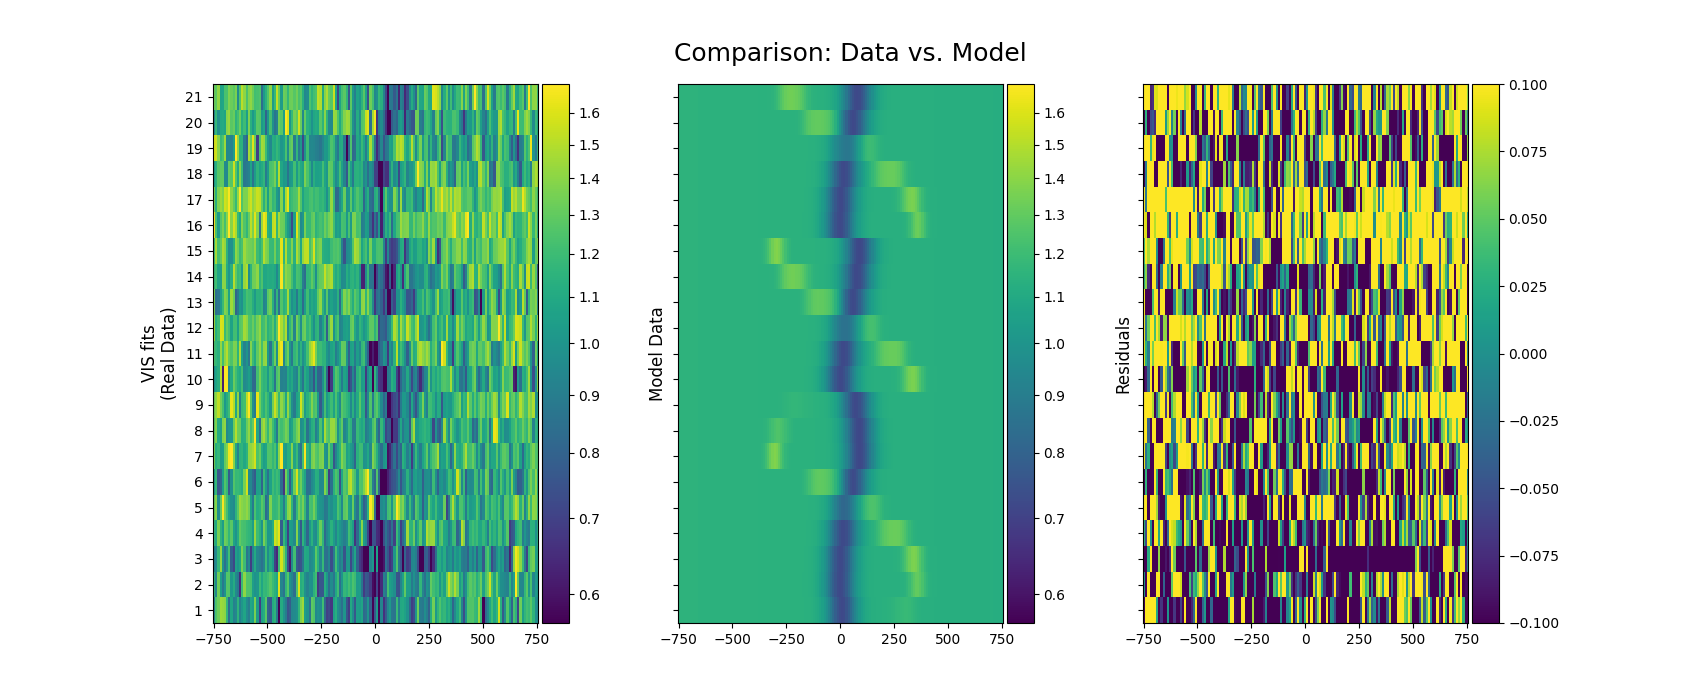

In [14]:
def plot_comparison():
    real_data, _, vmin, vmax, n_files= \
        plot_trailing_spectra_modified(trailing_data, common_velocity_axis[velocity_mask], min_v, max_v, binsize)
    
    fig, axes = plt.subplots(1,3, figsize=(17, 7), sharex=True, sharey=True, gridspec_kw={'hspace': 0.15})
    fig.suptitle('Comparison: Data vs. Model', fontsize=18, y=0.94)
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    plot_extent = [min_v - binsize / 2, max_v + binsize / 2, 0.5, n_files + 0.5]
    im1 = axes[0].imshow(normalised_trailing_data_masked, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=norm, cmap='viridis')

    axes[0].set_ylabel('VIS fits\n(Real Data)', fontsize=12)
    axes[0].set_yticks(np.arange(1, n_files + 1))
    cbar1 = fig.colorbar(im1, ax=axes[0], pad=0.01)
    ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    cbar1.set_ticks(ticks) 
    formatted_ticks = ["%.1f" % t for t in ticks]
    cbar1.set_ticklabels(formatted_ticks)
    
    orbitalphase = orbitalphasefunc() 
    
    model_data = generate_model_data(leastsqparams)

    im2 = axes[1].imshow(model_data, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=norm, cmap='viridis')
    axes[1].set_ylabel('Model Data', fontsize=12)
    cbar2 = fig.colorbar(im2, ax=axes[1], pad=0.01)
    ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    cbar2.set_ticks(ticks) 
    formatted_ticks = ["%.1f" % t for t in ticks]
    cbar2.set_ticklabels(formatted_ticks)
 
    residual = real_data - model_data
    res_norm = colors.Normalize(vmin=-0.1, vmax=0.1)
    
    im3 = axes[2].imshow(residual, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=res_norm, cmap='viridis')
    cbar3 = fig.colorbar(im3, ax=axes[2], pad=0.01)
    axes[2].set_ylabel('Residuals', fontsize=12)
    
    plt.show()
    plt.savefig("comparisonnew.png")


plot_comparison()